In [ ]:
#| default_exp models.nhits

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# NHITS

Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the Neural Hierarchical Interpolation for Time Series (NHITS). `NHITS` builds upon `NBEATS` and specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input
processing. On the long-horizon forecasting task `NHITS` improved accuracy by 25% on AAAI's best paper award the `Informer`, while being 50x faster.

The model is composed of several MLPs with ReLU non-linearities. Blocks are connected via doubly residual stacking principle with the backcast $\mathbf{\tilde{y}}_{t-L:t,l}$ and forecast $\mathbf{\hat{y}}_{t+1:t+H,l}$ outputs of the l-th block. Multi-rate input pooling, hierarchical interpolation and backcast residual connections together induce the specialization of the additive predictions in different signal bands, reducing memory footprint and computational time, thus improving the architecture parsimony and accuracy.

**References**<br>
-[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)<br>
-[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2022). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting".](https://arxiv.org/abs/2201.12886)<br>
-[Zhou, H.; Zhang, S.; Peng, J.; Zhang, S.; Li, J.; Xiong, H.; and Zhang, W. (2020). "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting". Association for the Advancement of Artificial Intelligence Conference 2021 (AAAI 2021).](https://arxiv.org/abs/2012.07436)

![Figure 1. Neural Hierarchical Interpolation for Time Series (N-HITS).](imgs_models/nhits.png)

In [ ]:
#| export
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [ ]:
#| hide
import logging
import warnings

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

#plt.rcParams["axes.grid"]=True
plt.rcParams['font.family'] = 'serif'
#plt.rcParams["figure.figsize"] = (4,2)

In [ ]:
#| export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, 
                 interpolation_mode: str, out_features: int=1):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
        self.out_features = out_features
 
    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        # Interpolation is performed on default dim=-1 := H
        knots = knots.reshape(len(knots), self.out_features, -1)
        if self.interpolation_mode in ['nearest', 'linear']:
            #knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            #forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            batch_size = len(backcast)
            knots = knots[:,None,:,:]
            forecast = torch.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], 
                                           size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,:,:]

        # [B,Q,H] -> [B,H,Q]
        forecast = forecast.permute(0, 2, 1)
        return backcast, forecast

In [ ]:
#| exporti
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

POOLING = ['MaxPool1d',
           'AvgPool1d']

class NHITSBlock(nn.Module):
    """
    N-HiTS block which takes a basis function as an argument.
    """
    def __init__(self, 
                 input_size: int,
                 h: int,
                 n_theta: int,
                 mlp_units: list,
                 basis: nn.Module,
                 futr_input_size: int,
                 hist_input_size: int,
                 stat_input_size: int,
                 n_pool_kernel_size: int,
                 pooling_mode: str,
                 dropout_prob: float,
                 activation: str):
        super().__init__()

        pooled_hist_size = int(np.ceil(input_size/n_pool_kernel_size))
        pooled_futr_size = int(np.ceil((input_size+h)/n_pool_kernel_size))

        input_size = pooled_hist_size + \
                     hist_input_size * pooled_hist_size + \
                     futr_input_size * pooled_futr_size + stat_input_size

        self.dropout_prob = dropout_prob
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.stat_input_size = stat_input_size
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        assert pooling_mode in POOLING, f'{pooling_mode} is not in {POOLING}'

        activ = getattr(nn, activation)()

        self.pooling_layer = getattr(nn, pooling_mode)(kernel_size=n_pool_kernel_size,
                                                       stride=n_pool_kernel_size, ceil_mode=True)

        # Block MLPs
        hidden_layers = [nn.Linear(in_features=input_size, 
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0], 
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                raise NotImplementedError('dropout')
                #hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, futr_exog: torch.Tensor,
                hist_exog: torch.Tensor, stat_exog: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Pooling
        # Pool1d needs 3D input, (B,C,L), adding C dimension
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            hist_exog = hist_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            hist_exog = self.pooling_layer(hist_exog)
            hist_exog = hist_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            futr_exog = futr_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            futr_exog = self.pooling_layer(futr_exog)
            futr_exog = futr_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

In [ ]:
#| export
class NHITS(BaseWindows):
    """ NHITS

    The Neural Hierarchical Interpolation for Time Series (NHITS), is an MLP-based deep
    neural architecture with backward and forward residual links. NHITS tackles volatility and
    memory complexity challenges, by locally specializing its sequential predictions into
    the signals frequencies with hierarchical interpolation and pooling.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `stack_types`: List[str], List of stack types. Subset from ['seasonality', 'trend', 'identity'].<br>
    `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
    `mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
    `n_harmonics`: int, Number of harmonic terms for seasonality stack type. Note that len(n_harmonics) = len(stack_types). Note that it will only be used if a seasonality stack is used.<br>
    `n_polynomials`: int, polynomial degree for trend stack. Note that len(n_polynomials) = len(stack_types). Note that it will only be used if a trend stack is used.<br>
    `dropout_prob_theta`: float, Float between (0, 1). Dropout for N-BEATS basis.<br>
    `learning_rate`: float, Learning rate between (0, 1).<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References:**<br>
    -[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, 
    Max Mergenthaler-Canseco, Artur Dubrawski (2022). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting".](https://arxiv.org/abs/2201.12886)
    """
    def __init__(self, 
                 h,
                 input_size,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,                 
                 stack_types: list = ['identity', 'identity', 'identity'],
                 n_blocks: list = [1, 1, 1],
                 mlp_units: list = 3 * [[512, 512]],
                 n_pool_kernel_size: list = [2, 2, 1],
                 n_freq_downsample: list = [4, 2, 1],
                 pooling_mode: str = 'MaxPool1d',
                 interpolation_mode: str = 'linear',
                 dropout_prob_theta = 0.,
                 activation = 'ReLU',
                 loss=MAE(),
                 learning_rate=1e-3,
                 batch_size=32,
                 windows_batch_size: int = 1024,
                 step_size: int = 1,
                 scaler_type=None,
                 random_seed=1,
                 num_workers_loader=0,
                 drop_last_loader=False,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(NHITS, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,                                    
                                    loss=loss,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    **trainer_kwargs)

        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        blocks = self.create_stack(h=h,
                                   input_size=input_size,
                                   stack_types=stack_types,
                                   futr_input_size=self.futr_input_size,
                                   hist_input_size=self.hist_input_size,
                                   stat_input_size=self.stat_input_size,                                   
                                   n_blocks=n_blocks,
                                   mlp_units=mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation)
        self.blocks = torch.nn.ModuleList(blocks)

    def create_stack(self,
                     h, 
                     input_size,    
                     stack_types, 
                     n_blocks,
                     mlp_units,
                     n_pool_kernel_size,
                     n_freq_downsample,
                     pooling_mode,
                     interpolation_mode,
                     dropout_prob_theta, 
                     activation,
                     futr_input_size, hist_input_size, stat_input_size):                     

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                assert stack_types[i] == 'identity', f'Block type {stack_types[i]} not found!'

                n_theta = (input_size + self.loss.outputsize_multiplier*max(h//n_freq_downsample[i], 1) )
                basis = _IdentityBasis(backcast_size=input_size, forecast_size=h,
                                       out_features=self.loss.outputsize_multiplier,
                                       interpolation_mode=interpolation_mode)

                nbeats_block = NHITSBlock(h=h,
                                          input_size=input_size,
                                          futr_input_size=futr_input_size,
                                          hist_input_size=hist_input_size,
                                          stat_input_size=stat_input_size,                                          
                                          n_theta=n_theta,
                                          mlp_units=mlp_units,
                                          n_pool_kernel_size=n_pool_kernel_size[i],
                                          pooling_mode=pooling_mode,
                                          basis=basis,
                                          dropout_prob=dropout_prob_theta,
                                          activation=activation)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)
                
        return block_list

    def forward(self, windows_batch):
        
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']
        
        # insample
        residuals = insample_y.flip(dims=(-1,)) #backcast init
        insample_mask = insample_mask.flip(dims=(-1,))
        
        forecast = insample_y[:, -1:, None] # Level with Naive1
        block_forecasts = [ forecast.repeat(1, self.h, 1) ]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, futr_exog=futr_exog,
                                             hist_exog=hist_exog, stat_exog=stat_exog)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            
            if self.decompose_forecast:
                block_forecasts.append(block_forecast)
        
        # Adapting output's domain
        forecast = self.loss.domain_map(forecast)

        if self.decompose_forecast:
            # (n_batch, n_blocks, h, output_size)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2,3)
            block_forecasts = block_forecasts.squeeze(-1) # univariate output
            return block_forecasts
        else:
            return forecast

In [ ]:
show_doc(NHITS)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/nhits.py#L154){target="_blank" style="float:right; font-size:smaller"}

### NHITS

>      NHITS (h, input_size, futr_exog_list=None, hist_exog_list=None,
>             stat_exog_list=None, stack_types:list=['identity', 'identity',
>             'identity'], n_blocks:list=[1, 1, 1], mlp_units:list=[[512, 512],
>             [512, 512], [512, 512]], n_pool_kernel_size:list=[2, 2, 1],
>             n_freq_downsample:list=[4, 2, 1], pooling_mode:str='MaxPool1d',
>             interpolation_mode:str='linear', dropout_prob_theta=0.0,
>             activation='ReLU', loss=MAE(), learning_rate=0.001, batch_size=32,
>             windows_batch_size:int=1024, step_size:int=1, scaler_type=None,
>             random_seed=1, num_workers_loader=0, drop_last_loader=False,
>             **trainer_kwargs)

NHITS

The Neural Hierarchical Interpolation for Time Series (NHITS), is an MLP-based deep
neural architecture with backward and forward residual links. NHITS tackles volatility and
memory complexity challenges, by locally specializing its sequential predictions into
the signals frequencies with hierarchical interpolation and pooling.

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
`activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
`stack_types`: List[str], List of stack types. Subset from ['seasonality', 'trend', 'identity'].<br>
`n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
`mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
`n_harmonics`: int, Number of harmonic terms for seasonality stack type. Note that len(n_harmonics) = len(stack_types). Note that it will only be used if a seasonality stack is used.<br>
`n_polynomials`: int, polynomial degree for trend stack. Note that len(n_polynomials) = len(stack_types). Note that it will only be used if a trend stack is used.<br>
`dropout_prob_theta`: float, Float between (0, 1). Dropout for N-BEATS basis.<br>
`learning_rate`: float, Learning rate between (0, 1).<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References:**<br>
-[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, 
Max Mergenthaler-Canseco, Artur Dubrawski (2022). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting".](https://arxiv.org/abs/2201.12886)

In [ ]:
show_doc(NHITS.fit, name='NHITS.fit')

---

### NHITS.fit

>      NHITS.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization. 
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect 
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(NHITS.predict, name='NHITS.predict')

---

### NHITS.predict

>      NHITS.predict (dataset, test_size=None, step_size=1,
>                     **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

In [ ]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<AxesSubplot: xlabel='ds'>

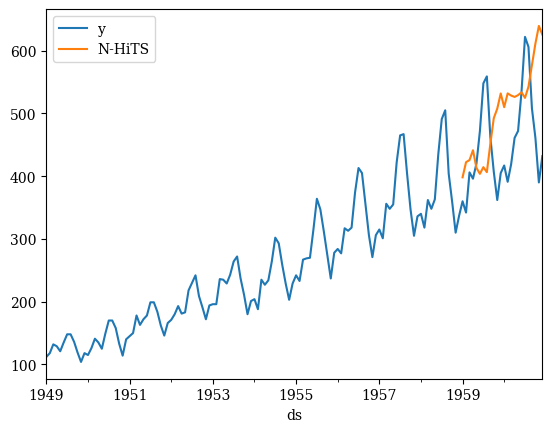

In [ ]:
#| hide
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = Y_df[Y_df.ds<Y_df['ds'].values[-24]] # 132 train
Y_test_df = Y_df[Y_df.ds>=Y_df['ds'].values[-24]] # 12 test

dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
model = NHITS(h=24, input_size=24*2, max_epochs=1,
              windows_batch_size=None, 
              n_freq_downsample=[12,4,1], 
              pooling_mode='MaxPool1d')
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)
Y_test_df['N-HiTS'] = y_hat

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

Predicting: 0it [00:00, ?it/s]

Text(0.5, 0, 'Prediction τ ∈ {t+1,..., t+H}')

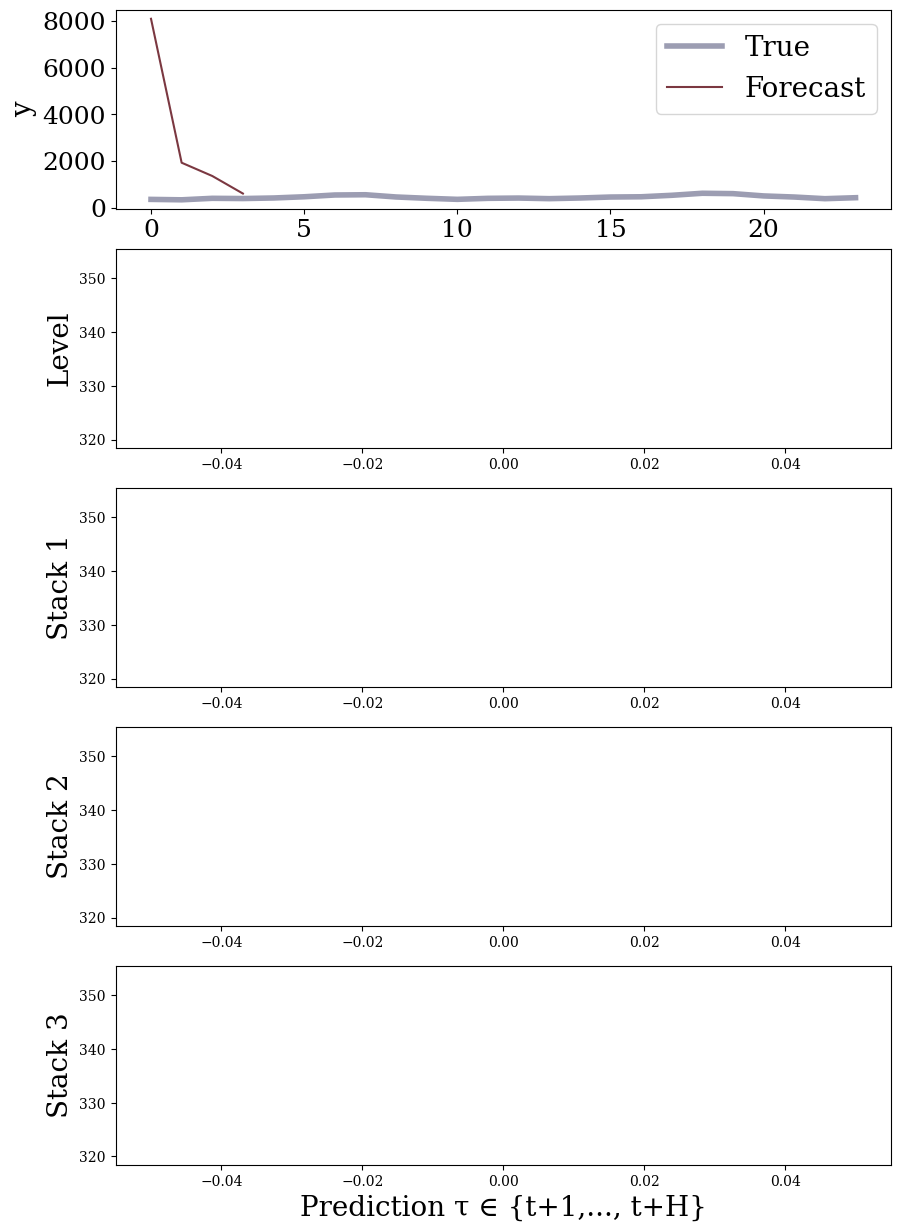

In [ ]:
#| hide
# qualitative decomposition evaluation
y_hat = model.decompose(dataset=dataset)

fig, ax = plt.subplots(5, 1, figsize=(10, 15))

ax[0].plot(Y_test_df['y'].values, label='True', color="#9C9DB2", linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend(prop={'size': 20})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)
ax[0].set_ylabel('y', fontsize=20)

ax[1].plot(y_hat[0,0], label='level', color="#7B3841")
ax[1].set_ylabel('Level', fontsize=20)

ax[2].plot(y_hat[0,1], label='stack1', color="#7B3841")
ax[2].set_ylabel('Stack 1', fontsize=20)

ax[3].plot(y_hat[0,2], label='stack2', color="#D9AE9E")
ax[3].set_ylabel('Stack 2', fontsize=20)

ax[4].plot(y_hat[0,3], label='stack3', color="#D9AE9E")
ax[4].set_ylabel('Stack 3', fontsize=20)

ax[4].set_xlabel('Prediction \u03C4 \u2208 {t+1,..., t+H}', fontsize=20)

## Usage Example

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

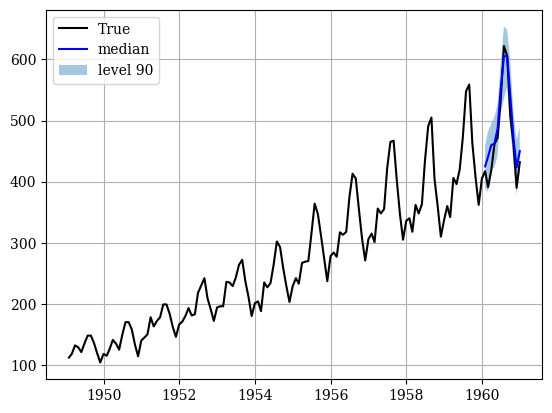

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NHITS(h=12, input_size=24,
              #loss=MQLoss(level=[80, 90]),
              loss=PMM(n_lambdas=5, level=[80, 90]),
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              #scaler_type='robust',
              scaler_type=None,
              max_epochs=100)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'], 
                 y1=plot_df['NHITS-lo-90.0'], y2=plot_df['NHITS-hi-90.0'],
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()